# Importation

---



Importer les données de Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = "/content/gdrive/My Drive/Gym_trainer/openpose/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Importer les différents modules python

In [5]:
import numpy as np

from itertools import product
from keras.callbacks import LearningRateScheduler
from keras.layers import  BatchNormalization, Convolution1D, Dense, Dropout, Flatten, MaxPooling1D, SpatialDropout1D, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from IPython.display import HTML
from math import floor, sqrt
from matplotlib import animation
from matplotlib import pyplot as plt
from pickle import load
from scipy import stats

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 18})

Using TensorFlow backend.


---

# Définitions des fonctions

---

## Traitement sur les données

Remplir les matrices avec des 0 pour qu'elles aient toutes la même taille

In [0]:
def pad_matrices(matrix_list):
  """Pad matrices with 0."""
  max_length = 0
  new_matrix_list = []
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape[1]
    if shape > max_length:
      max_length = shape
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape
    if shape[0] < max_length: # matrix_list[1].shape[0]
      pad_length = max_length - shape[1]
      pad = np.zeros((2, pad_length, shape[2]))
      new_matrix = np.append(matrix_list[i], pad, axis=1)
    else:
      new_matrix = matrix_list[i]
      print("pas de pad")
    new_matrix_list.append(new_matrix)
  new_matrix_list = np.array(new_matrix_list)
  return new_matrix_list

Découper les données entre ensemble de test et ensemble d'apprentissage

In [0]:
def split_data(X, y, indice):
  """Split data betwenn train set and test set."""
  X_test = []
  y_test = []
  X_train = []
  y_train = []
  for i in range(len(y)):
    if i in indice:
      X_test.append(X[i])
      y_test.append(y[i])
    else:
      X_train.append(X[i])
      y_train.append(y[i])
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return (X_test , y_test, X_train, y_train)

Transformer les données

In [0]:
def transform_matrices(X):
  """Transform data."""
  shape = X.shape
  new_X = np.zeros((shape[0], shape[2], shape[1] * shape[3]))
  for i in range(shape[0]):
    for j in range(shape[2]):
      new_X[i, j ,:] = np.reshape(X[i, :, j, :], (1, shape[1] * shape[3]))
  return new_X

Supprimer les zéros lorsqu'une articulation n'est pas détectée

In [0]:
def delete_zeros(X):
  """Delete zeros in matrices and replace them with the previous value."""
  for i in range(len(X)):
    matrix = X[i]
    shape = matrix.shape
    for (j,k) in product(range(shape[1]), range(shape[2])):
      if matrix[0, j, k] == 0:
        matrix[:, j, k] = matrix[:, j - 1, k]
  X[i] = matrix
  return X

Normaliser les données

In [0]:
def standardize(X):
  """Standardize data according to a normal distribution."""
  for i in range(X.shape[2]):
    mu = np.mean(X[:, :, i])
    sigma = np.std(X[:, :, i])
    if sigma != 0:
      X[:, :, i] = (X[:, :, i] - mu) / sigma
  return X

## Modèle

Définir le modèle du CNN

In [0]:
def define_model(dim1, dim2):
  """Define the model of the CNN with (dim1, dim2) as input shape."""
  shape = (dim1, dim2)
  model = Sequential()
  model.add(Convolution1D(16, 3, activation='relu', input_shape=shape))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(32, 3, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(64, 3, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(128, 3, activation='relu'))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Flatten())
  model.add(Dense(50,  activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1,  activation='linear'))
  model.summary()
  return model

## Affichage

Afficher l'historique du modèle

In [0]:
def print_history(history, name):
  """Summarize history by printing the loss of the model."""
  fig, ax = plt.subplots(figsize=(10,10))
  ax.plot(history.history['loss'])
  ax.plot(history.history['val_loss'])
  ax.set(title='model loss (' + name + 'th person)', ylabel='loss', xlabel='epoch')
  ax.legend(['train', 'test'], loc='upper left')
  ax.grid(True, linestyle='-.')
  plt.show()

Afficher les résultats du modèle



In [0]:
def print_results(model, X_test, y_test, X_train, y_train):
  """Print the results of the model."""
  predict_test = model.predict(X_test)
  RMSE_test = np.linalg.norm(predict_test - y_test) / len(y_test)
  print("RMSE test", RMSE_test)
  predict_test = predict_test.flatten()
  corr = np.corrcoef(y_test, predict_test)
  print("corr test", corr[0,1])
  plt.plot(y_test, np.array(predict_test), '.r')
  plt.title('Predicted/real values on test set')
  plt.xlabel('real values')
  plt.ylabel('predicted values')
  plt.show()
  predict_train = model.predict(X_train)
  RMSE_train = np.linalg.norm(predict_train - y_train) / len(y_train)
  print("RMSE train", RMSE_train)
  predict_train = predict_train.flatten()
  corr = np.corrcoef(y_train, predict_train)
  print("corr test", corr[0,1])
  plt.plot(y_train, np.array(predict_train), '.r')
  plt.title('Predicted/real values on train set')
  plt.xlabel('real values')
  plt.ylabel('predicted values')
  plt.show()

Afficher les articulations dans une animation

In [0]:
def print_joints(X, video):
  "Plot an animation of the joints of the video at position 'video' in 'X'."
  fig, ax = plt.subplots(figsize=(10,10))
  joints, = ax.plot([], [], 'r.')
  left_arm, = ax.plot([], [], 'b-')
  right_arm, = ax.plot([], [], 'b-')
  ax.set(title='OpenPose', xlabel='x',
          ylabel='-y', ylim=(-1000,0), xlim=(400,1000))
  ax.grid(True, linestyle='-.')
  def init():
      joints.set_data([], [])
      left_arm.set_data([], [])
      right_arm.set_data([], [])
      return joints, left_arm, right_arm,
  def animate(frame):
      joints.set_data(X[video][0,frame,:],-X[video][1,frame,:])
      left_arm.set_data(X[video][0,frame,0:4],-X[video][1,frame,0:4])
      ra = [0, 4, 5, 6]
      right_arm.set_data(X[video][0,frame,ra],-X[video][1,frame,ra])
      return joints, left_arm, right_arm,
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=X[video].shape[1], interval=150, blit=True)
  return HTML(anim.to_html5_video())

#print_joints(X,0)

---

# Programme

---

Charger les données

In [0]:
# X = load(open(PATH + "Matrices.p", "rb"))
# Personnes = np.load(PATH + 'Personnes.npy')
# y = np.load(PATH + 'Notes.npy')

Charger les matrices geste par geste SANS les squats

In [46]:
import numpy as np
import os
import csv

PATH_OUT = PATH + 'output/'
PATH_CSV = PATH + 'csv/'
X_train = []
Y_train = []
Personnes = []
files = os.listdir(PATH_OUT)
files.sort()
for i in range(len(files)):
  f = files[i]
  print('i= ', i)
  # on parcourt chaque vidéo qui contient 9 mouvements
  path = PATH_CSV+f[0:3]+'.csv'
  # on ouvre le fichier csv correspondant content les infos
  with open(path) as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    tab = []
    y = []
    for row in csvReader:
#      print(row)
      if len(row) == 5: # vérifie si ce n'est pas une ligne vide
        if row[0][0:6] == f[0:-4] and int(row[1]) != 9: # vérifie si ce n'est pas un squat
          print(row)
          tab.append([int(row[2]), int(row[3])])
          y.append(float(row[4]))
        if row[0][0:6] == f[0:-4] and int(row[1]) == 9: # caduque, à enlever
          #print(row)
          indx = int(row[3])
          break
  Y_train.append(np.sum(y))
  temp = np.load(PATH_OUT+f)
  X_train.append(temp[: , tab[0][0]:tab[7][1], :])
  Personnes.append(int(f[1:3]))
np.save('data', (X_train, Y_train, Personnes))

i=  0
['P01_01.mts', '1', '22', '46', '4.5']
['P01_01.mts', '2', '47', '75', '5']
['P01_01.mts', '3', '76', '89', '4']
['P01_01.mts', '4', '90', '128', '5']
['P01_01.mts', '5', '129', '160', '5']
['P01_01.mts', '6', '161', '181', '5']
['P01_01.mts', '7', '182', '206', '4']
['P01_01.mts', '8', '207', '230', '4.5']
i=  1
['P01_02.mts', '1', '1', '23', '3.5']
['P01_02.mts', '2', '24', '54', '3']
['P01_02.mts', '3', '55', '64', '4']
['P01_02.mts', '4', '65', '85', '5']
['P01_02.mts', '5', '86', '121', '5']
['P01_02.mts', '6', '122', '135', '5']
['P01_02.mts', '7', '136', '155', '4']
['P01_02.mts', '8', '156', '177', '4']
i=  2
['P01_03.mts', '1', '44', '58', '3']
['P01_03.mts', '2', '59', '67', '4.5']
['P01_03.mts', '3', '68', '81', '5']
['P01_03.mts', '4', '82', '97', '5']
['P01_03.mts', '5', '98', '112', '4.5']
['P01_03.mts', '6', '113', '125', '5']
['P01_03.mts', '7', '126', '138', '4']
['P01_03.mts', '8', '139', '150', '4.5']
i=  3
['P01_04.mts', '1', '58', '69', '3']
['P01_04.mts', '2

In [0]:
(X, y, Personnes) = np.load('data.npy', allow_pickle=True)

Réduire le nombre d'articulations

In [0]:
for i in range(len(X)):
	X[i] = X[i][:,:,1:8]

Traiter les données

In [0]:
X = delete_zeros(X)

In [0]:
print_joints(X,0)

In [0]:
X = pad_matrices(X)
X = transform_matrices(X)
X = standardize(X)
y = y/40 # 45 si squat

Séparer les données

In [0]:
# indice = 40
# X_test , y_test, X_train, y_train = split_data(X,y, indice)

Créer le modèle

In [63]:
optimizer = Adam(lr=.001)
batch_size = 32
nb_epochs = 200
# lrate = LearningRateScheduler(step_decay)
model = define_model(X.shape[1], X.shape[2])
model.compile(loss='MSE', optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 265, 16)           688       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 88, 16)            0         
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 88, 16)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 86, 32)            1568      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 28, 32)            0         
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 28, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 26, 64)           

Faire tourner le modèle tout d'un coup

In [0]:
# history = model.fit(X_train, y_train, epochs=nb_epochs, verbose=0,
#                    validation_data=(X_test, y_test), shuffle=True)
# print_history(history)
# print_results(model, X_test, y_test, X_train, y_train)

Faire tourner le modèle personne par personne

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 1s 3ms/step - loss: 0.2561 - val_loss: 0.2965
Epoch 2/200
200/200 [==============================] - 0s 312us/step - loss: 0.1148 - val_loss: 0.2200
Epoch 3/200
200/200 [==============================] - 0s 327us/step - loss: 0.0985 - val_loss: 0.2545
Epoch 4/200
200/200 [==============================] - 0s 401us/step - loss: 0.0902 - val_loss: 0.2652
Epoch 5/200
200/200 [==============================] - 0s 309us/step - loss: 0.0884 - val_loss: 0.2109
Epoch 6/200
200/200 [==============================] - 0s 329us/step - loss: 0.0742 - val_loss: 0.2149
Epoch 7/200
200/200 [==============================] - 0s 309us/step - loss: 0.0738 - val_loss: 0.1798
Epoch 8/200
200/200 [==============================] - 0s 318us/step - loss: 0.0913 - val_loss: 0.2329
Epoch 9/200
200/200 [==============================] - 0s 380us/step - loss: 0.0676 - val_loss: 0.1604
Epoch 10/200
200/200 [========

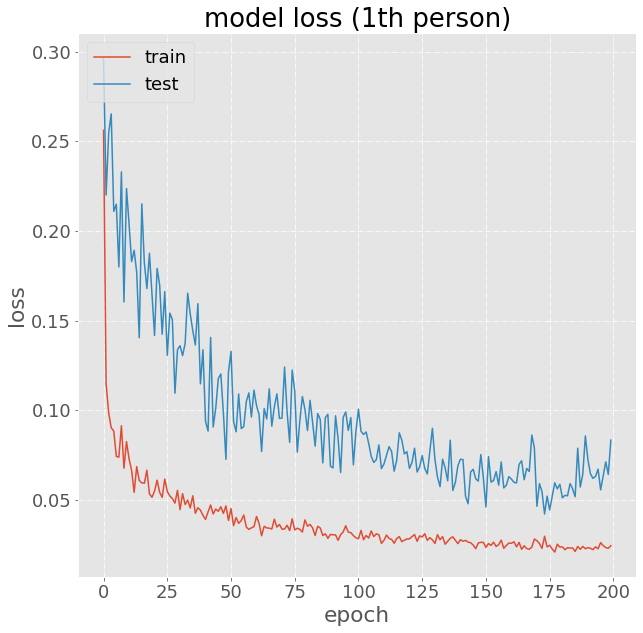

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 385us/step - loss: 0.0261 - val_loss: 0.0056
Epoch 2/200
200/200 [==============================] - 0s 338us/step - loss: 0.0258 - val_loss: 0.0059
Epoch 3/200
200/200 [==============================] - 0s 332us/step - loss: 0.0253 - val_loss: 0.0062
Epoch 4/200
200/200 [==============================] - 0s 340us/step - loss: 0.0260 - val_loss: 0.0061
Epoch 5/200
200/200 [==============================] - 0s 337us/step - loss: 0.0252 - val_loss: 0.0050
Epoch 6/200
200/200 [==============================] - 0s 330us/step - loss: 0.0225 - val_loss: 0.0049
Epoch 7/200
200/200 [==============================] - 0s 327us/step - loss: 0.0246 - val_loss: 0.0058
Epoch 8/200
200/200 [==============================] - 0s 376us/step - loss: 0.0195 - val_loss: 0.0050
Epoch 9/200
200/200 [==============================] - 0s 341us/step - loss: 0.0237 - val_loss: 0.0063
Epoch 10/200
200/200 [======

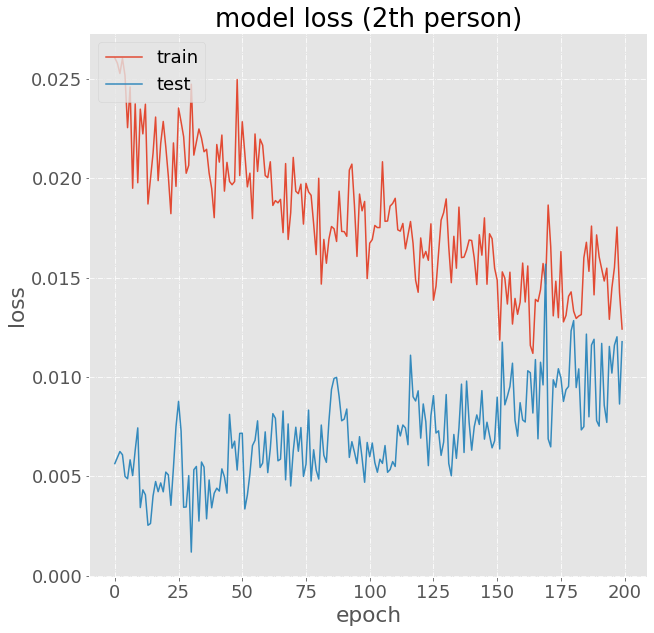

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 336us/step - loss: 0.0148 - val_loss: 0.0142
Epoch 2/200
200/200 [==============================] - 0s 321us/step - loss: 0.0155 - val_loss: 0.0130
Epoch 3/200
200/200 [==============================] - 0s 313us/step - loss: 0.0128 - val_loss: 0.0082
Epoch 4/200
200/200 [==============================] - 0s 333us/step - loss: 0.0129 - val_loss: 0.0125
Epoch 5/200
200/200 [==============================] - 0s 363us/step - loss: 0.0158 - val_loss: 0.0165
Epoch 6/200
200/200 [==============================] - 0s 329us/step - loss: 0.0157 - val_loss: 0.0132
Epoch 7/200
200/200 [==============================] - 0s 316us/step - loss: 0.0163 - val_loss: 0.0096
Epoch 8/200
200/200 [==============================] - 0s 310us/step - loss: 0.0144 - val_loss: 0.0094
Epoch 9/200
200/200 [==============================] - 0s 329us/step - loss: 0.0152 - val_loss: 0.0093
Epoch 10/200
200/200 [======

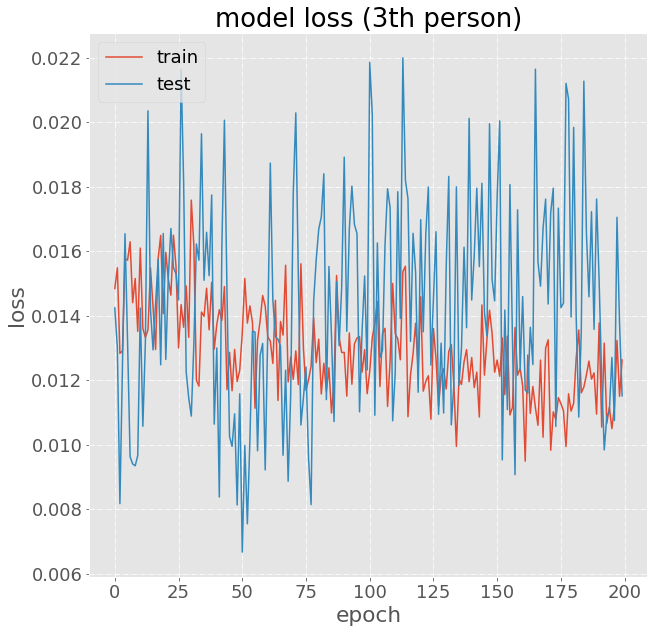

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 344us/step - loss: 0.0116 - val_loss: 0.0026
Epoch 2/200
200/200 [==============================] - 0s 322us/step - loss: 0.0112 - val_loss: 0.0024
Epoch 3/200
200/200 [==============================] - 0s 315us/step - loss: 0.0098 - val_loss: 0.0021
Epoch 4/200
200/200 [==============================] - 0s 341us/step - loss: 0.0105 - val_loss: 0.0018
Epoch 5/200
200/200 [==============================] - 0s 361us/step - loss: 0.0091 - val_loss: 0.0017
Epoch 6/200
200/200 [==============================] - 0s 385us/step - loss: 0.0110 - val_loss: 0.0019
Epoch 7/200
200/200 [==============================] - 0s 349us/step - loss: 0.0109 - val_loss: 0.0021
Epoch 8/200
200/200 [==============================] - 0s 311us/step - loss: 0.0109 - val_loss: 0.0028
Epoch 9/200
200/200 [==============================] - 0s 312us/step - loss: 0.0115 - val_loss: 0.0038
Epoch 10/200
200/200 [======

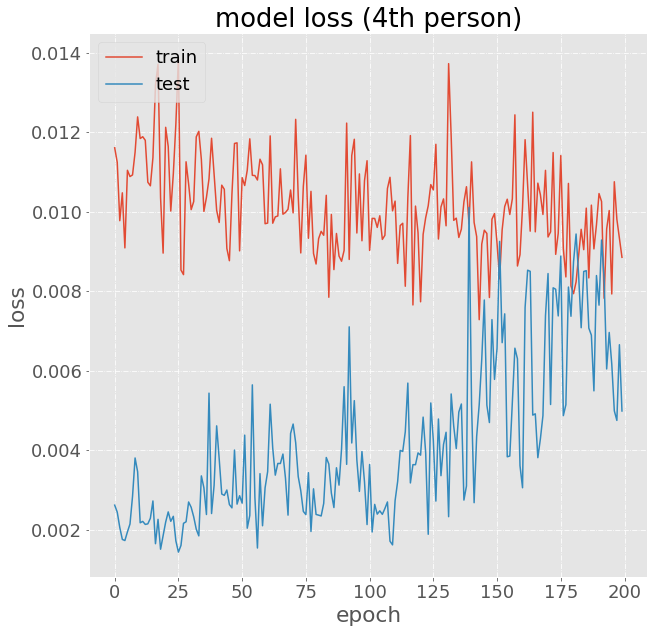

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 351us/step - loss: 0.0093 - val_loss: 0.0039
Epoch 2/200
200/200 [==============================] - 0s 309us/step - loss: 0.0100 - val_loss: 0.0032
Epoch 3/200
200/200 [==============================] - 0s 314us/step - loss: 0.0093 - val_loss: 0.0032
Epoch 4/200
200/200 [==============================] - 0s 320us/step - loss: 0.0083 - val_loss: 0.0046
Epoch 5/200
200/200 [==============================] - 0s 314us/step - loss: 0.0097 - val_loss: 0.0052
Epoch 6/200
200/200 [==============================] - 0s 323us/step - loss: 0.0089 - val_loss: 0.0028
Epoch 7/200
200/200 [==============================] - 0s 313us/step - loss: 0.0082 - val_loss: 0.0019
Epoch 8/200
200/200 [==============================] - 0s 325us/step - loss: 0.0083 - val_loss: 0.0031
Epoch 9/200
200/200 [==============================] - 0s 328us/step - loss: 0.0089 - val_loss: 0.0032
Epoch 10/200
200/200 [======

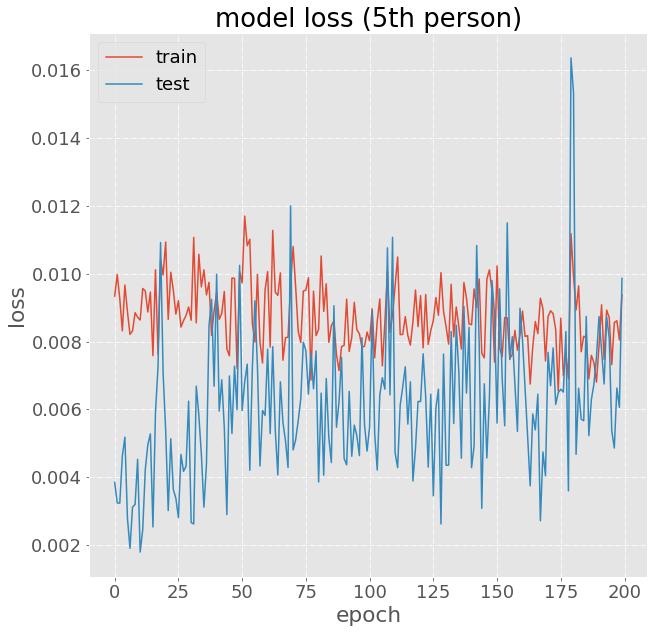

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 451us/step - loss: 0.0078 - val_loss: 0.0102
Epoch 2/200
200/200 [==============================] - 0s 329us/step - loss: 0.0079 - val_loss: 0.0052
Epoch 3/200
200/200 [==============================] - 0s 315us/step - loss: 0.0087 - val_loss: 0.0161
Epoch 4/200
200/200 [==============================] - 0s 361us/step - loss: 0.0069 - val_loss: 0.0053
Epoch 5/200
200/200 [==============================] - 0s 316us/step - loss: 0.0078 - val_loss: 0.0088
Epoch 6/200
200/200 [==============================] - 0s 333us/step - loss: 0.0070 - val_loss: 0.0070
Epoch 7/200
200/200 [==============================] - 0s 299us/step - loss: 0.0091 - val_loss: 0.0054
Epoch 8/200
200/200 [==============================] - 0s 326us/step - loss: 0.0078 - val_loss: 0.0142
Epoch 9/200
200/200 [==============================] - 0s 328us/step - loss: 0.0073 - val_loss: 0.0163
Epoch 10/200
200/200 [======

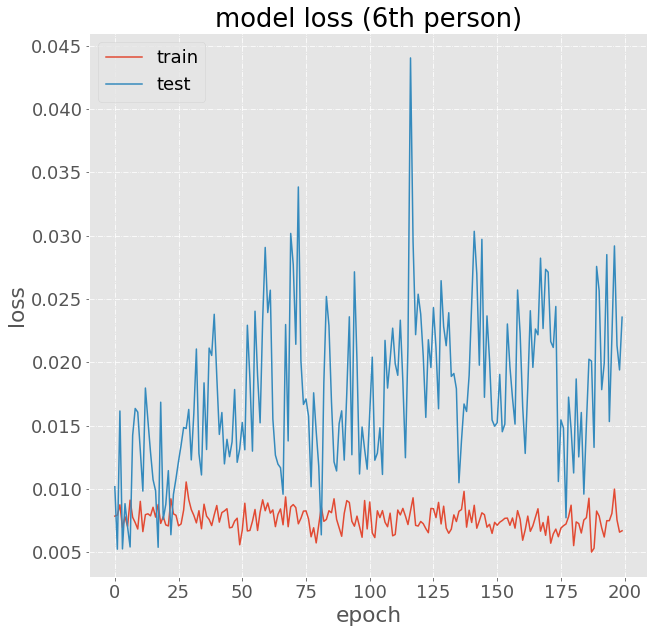

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 330us/step - loss: 0.0073 - val_loss: 0.0038
Epoch 2/200
200/200 [==============================] - 0s 324us/step - loss: 0.0080 - val_loss: 0.0021
Epoch 3/200
200/200 [==============================] - 0s 322us/step - loss: 0.0086 - val_loss: 0.0040
Epoch 4/200
200/200 [==============================] - 0s 327us/step - loss: 0.0080 - val_loss: 0.0042
Epoch 5/200
200/200 [==============================] - 0s 326us/step - loss: 0.0078 - val_loss: 0.0036
Epoch 6/200
200/200 [==============================] - 0s 416us/step - loss: 0.0082 - val_loss: 0.0016
Epoch 7/200
200/200 [==============================] - 0s 324us/step - loss: 0.0087 - val_loss: 0.0022
Epoch 8/200
200/200 [==============================] - 0s 310us/step - loss: 0.0067 - val_loss: 0.0033
Epoch 9/200
200/200 [==============================] - 0s 324us/step - loss: 0.0079 - val_loss: 0.0053
Epoch 10/200
200/200 [======

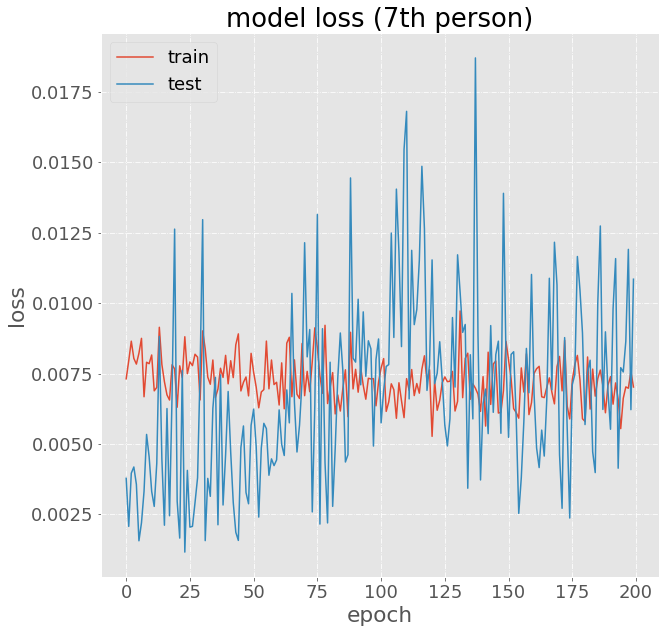

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 365us/step - loss: 0.0069 - val_loss: 0.0020
Epoch 2/200
200/200 [==============================] - 0s 327us/step - loss: 0.0086 - val_loss: 0.0023
Epoch 3/200
200/200 [==============================] - 0s 331us/step - loss: 0.0082 - val_loss: 0.0044
Epoch 4/200
200/200 [==============================] - 0s 343us/step - loss: 0.0079 - val_loss: 0.0017
Epoch 5/200
200/200 [==============================] - 0s 374us/step - loss: 0.0089 - val_loss: 0.0020
Epoch 6/200
200/200 [==============================] - 0s 340us/step - loss: 0.0069 - val_loss: 0.0029
Epoch 7/200
200/200 [==============================] - 0s 317us/step - loss: 0.0085 - val_loss: 0.0018
Epoch 8/200
200/200 [==============================] - 0s 322us/step - loss: 0.0072 - val_loss: 0.0020
Epoch 9/200
200/200 [==============================] - 0s 338us/step - loss: 0.0066 - val_loss: 0.0024
Epoch 10/200
200/200 [======

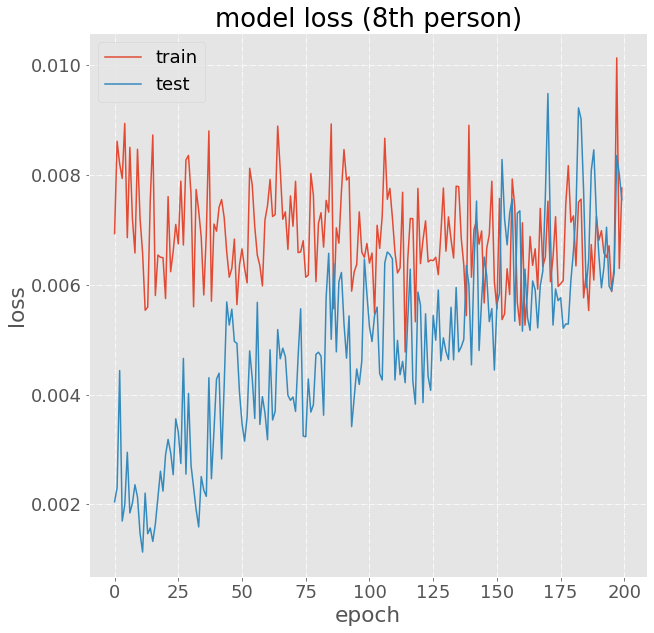

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 362us/step - loss: 0.0065 - val_loss: 0.0023
Epoch 2/200
200/200 [==============================] - 0s 334us/step - loss: 0.0058 - val_loss: 6.4172e-04
Epoch 3/200
200/200 [==============================] - 0s 352us/step - loss: 0.0060 - val_loss: 8.6959e-04
Epoch 4/200
200/200 [==============================] - 0s 319us/step - loss: 0.0059 - val_loss: 0.0018
Epoch 5/200
200/200 [==============================] - 0s 305us/step - loss: 0.0056 - val_loss: 0.0019
Epoch 6/200
200/200 [==============================] - 0s 317us/step - loss: 0.0062 - val_loss: 0.0015
Epoch 7/200
200/200 [==============================] - 0s 325us/step - loss: 0.0060 - val_loss: 0.0010
Epoch 8/200
200/200 [==============================] - 0s 332us/step - loss: 0.0062 - val_loss: 0.0014
Epoch 9/200
200/200 [==============================] - 0s 326us/step - loss: 0.0068 - val_loss: 0.0019
Epoch 10/200
200/200

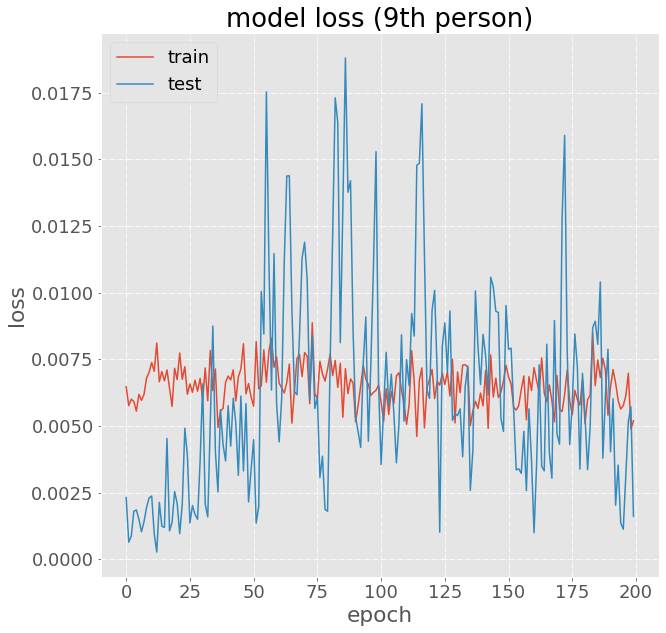

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 363us/step - loss: 0.0060 - val_loss: 0.0013
Epoch 2/200
200/200 [==============================] - 0s 312us/step - loss: 0.0067 - val_loss: 0.0015
Epoch 3/200
200/200 [==============================] - 0s 313us/step - loss: 0.0068 - val_loss: 7.8489e-04
Epoch 4/200
200/200 [==============================] - 0s 321us/step - loss: 0.0067 - val_loss: 7.1792e-04
Epoch 5/200
200/200 [==============================] - 0s 325us/step - loss: 0.0068 - val_loss: 0.0015
Epoch 6/200
200/200 [==============================] - 0s 317us/step - loss: 0.0050 - val_loss: 0.0017
Epoch 7/200
200/200 [==============================] - 0s 357us/step - loss: 0.0064 - val_loss: 0.0016
Epoch 8/200
200/200 [==============================] - 0s 306us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 9/200
200/200 [==============================] - 0s 321us/step - loss: 0.0076 - val_loss: 0.0019
Epoch 10/200
200/200

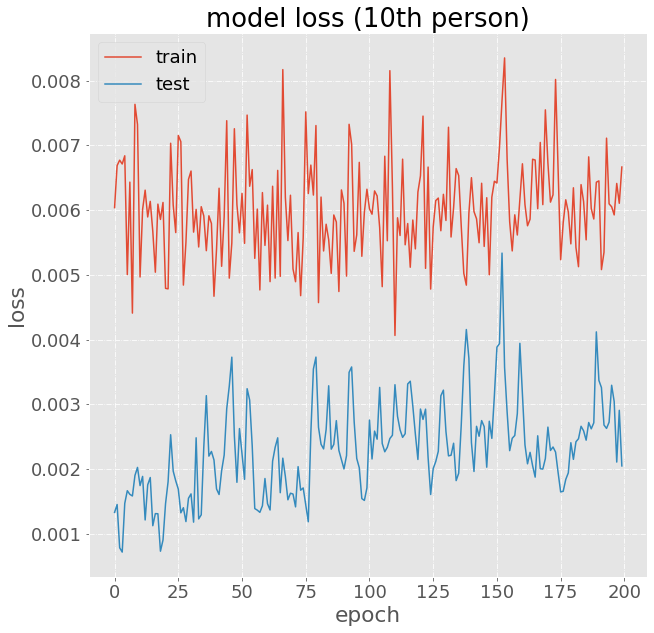

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 384us/step - loss: 0.0055 - val_loss: 9.9707e-04
Epoch 2/200
200/200 [==============================] - 0s 306us/step - loss: 0.0065 - val_loss: 0.0015
Epoch 3/200
200/200 [==============================] - 0s 306us/step - loss: 0.0082 - val_loss: 0.0018
Epoch 4/200
200/200 [==============================] - 0s 318us/step - loss: 0.0056 - val_loss: 0.0013
Epoch 5/200
200/200 [==============================] - 0s 309us/step - loss: 0.0076 - val_loss: 0.0010
Epoch 6/200
200/200 [==============================] - 0s 321us/step - loss: 0.0055 - val_loss: 0.0019
Epoch 7/200
200/200 [==============================] - 0s 333us/step - loss: 0.0068 - val_loss: 9.5238e-04
Epoch 8/200
200/200 [==============================] - 0s 324us/step - loss: 0.0061 - val_loss: 9.5309e-04
Epoch 9/200
200/200 [==============================] - 0s 325us/step - loss: 0.0056 - val_loss: 0.0013
Epoch 10/200
200

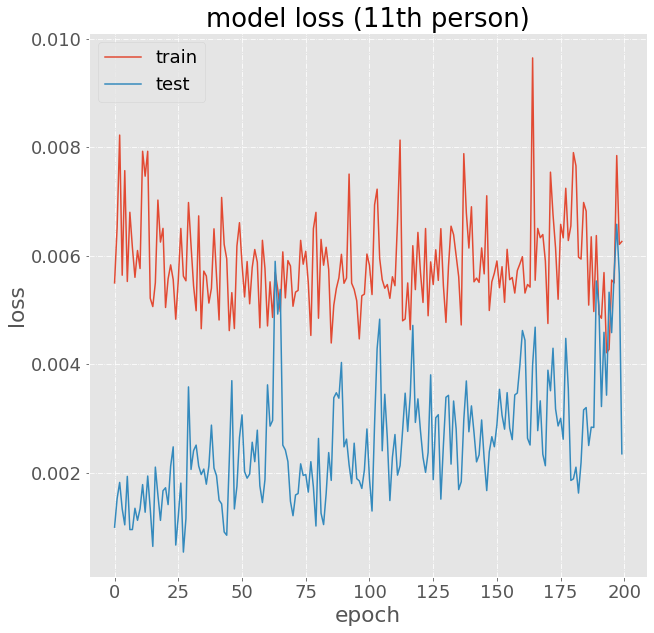

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 381us/step - loss: 0.0071 - val_loss: 0.0013
Epoch 2/200
200/200 [==============================] - 0s 313us/step - loss: 0.0075 - val_loss: 7.2011e-04
Epoch 3/200
200/200 [==============================] - 0s 303us/step - loss: 0.0055 - val_loss: 0.0023
Epoch 4/200
200/200 [==============================] - 0s 317us/step - loss: 0.0065 - val_loss: 9.6245e-04
Epoch 5/200
200/200 [==============================] - 0s 334us/step - loss: 0.0052 - val_loss: 0.0010
Epoch 6/200
200/200 [==============================] - 0s 339us/step - loss: 0.0058 - val_loss: 0.0024
Epoch 7/200
200/200 [==============================] - 0s 314us/step - loss: 0.0061 - val_loss: 0.0034
Epoch 8/200
200/200 [==============================] - 0s 377us/step - loss: 0.0059 - val_loss: 0.0021
Epoch 9/200
200/200 [==============================] - 0s 396us/step - loss: 0.0051 - val_loss: 0.0022
Epoch 10/200
200/200

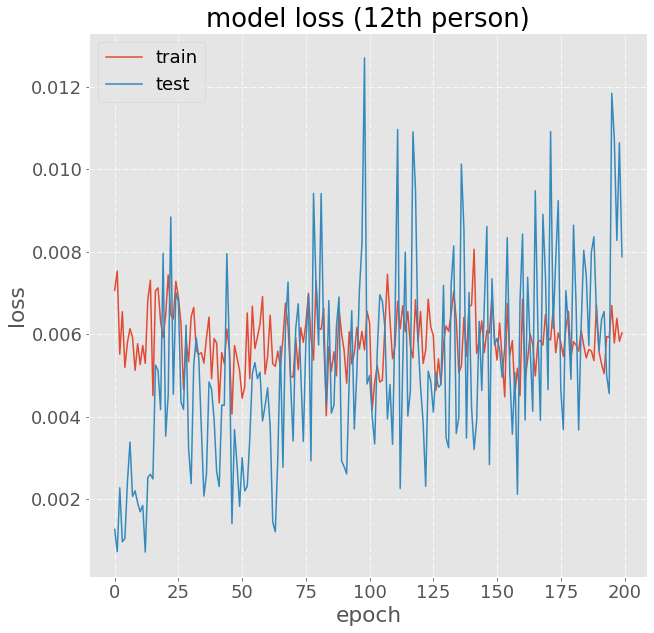

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 310us/step - loss: 0.0050 - val_loss: 4.4365e-04
Epoch 2/200
200/200 [==============================] - 0s 335us/step - loss: 0.0048 - val_loss: 2.7031e-04
Epoch 3/200
200/200 [==============================] - 0s 337us/step - loss: 0.0054 - val_loss: 3.6193e-04
Epoch 4/200
200/200 [==============================] - 0s 317us/step - loss: 0.0065 - val_loss: 8.8613e-04
Epoch 5/200
200/200 [==============================] - 0s 317us/step - loss: 0.0051 - val_loss: 0.0011
Epoch 6/200
200/200 [==============================] - 0s 334us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 7/200
200/200 [==============================] - 0s 322us/step - loss: 0.0056 - val_loss: 6.6198e-04
Epoch 8/200
200/200 [==============================] - 0s 323us/step - loss: 0.0056 - val_loss: 4.7784e-04
Epoch 9/200
200/200 [==============================] - 0s 311us/step - loss: 0.0056 - val_loss: 0.0014
Epoc

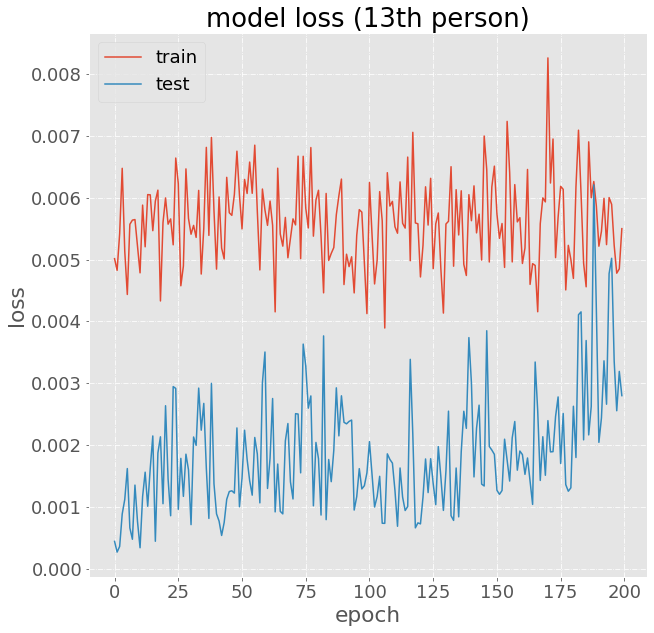

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 362us/step - loss: 0.0051 - val_loss: 7.3259e-04
Epoch 2/200
200/200 [==============================] - 0s 317us/step - loss: 0.0044 - val_loss: 9.7824e-04
Epoch 3/200
200/200 [==============================] - 0s 313us/step - loss: 0.0048 - val_loss: 8.1379e-04
Epoch 4/200
200/200 [==============================] - 0s 391us/step - loss: 0.0065 - val_loss: 8.3529e-04
Epoch 5/200
200/200 [==============================] - 0s 333us/step - loss: 0.0062 - val_loss: 8.7378e-04
Epoch 6/200
200/200 [==============================] - 0s 346us/step - loss: 0.0048 - val_loss: 0.0010
Epoch 7/200
200/200 [==============================] - 0s 316us/step - loss: 0.0071 - val_loss: 7.5316e-04
Epoch 8/200
200/200 [==============================] - 0s 315us/step - loss: 0.0053 - val_loss: 5.0415e-04
Epoch 9/200
200/200 [==============================] - 0s 322us/step - loss: 0.0077 - val_loss: 4.5665e

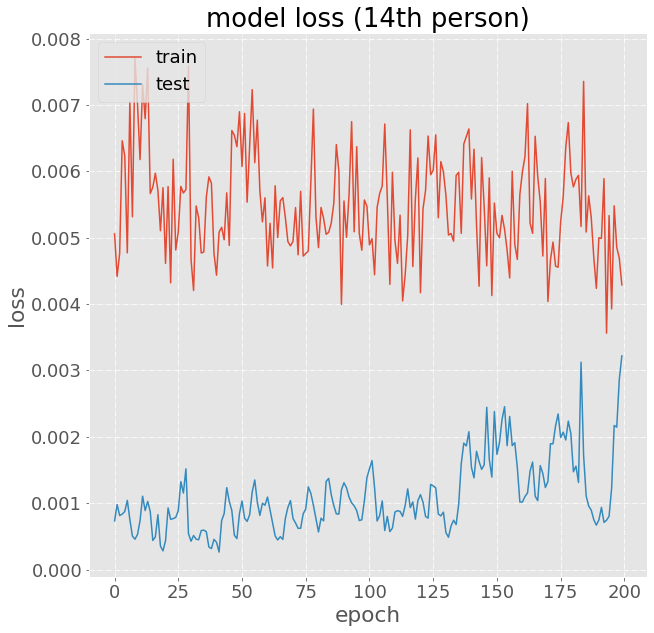

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 347us/step - loss: 0.0050 - val_loss: 2.6519e-04
Epoch 2/200
200/200 [==============================] - 0s 314us/step - loss: 0.0049 - val_loss: 2.6741e-04
Epoch 3/200
200/200 [==============================] - 0s 381us/step - loss: 0.0042 - val_loss: 3.3988e-04
Epoch 4/200
200/200 [==============================] - 0s 338us/step - loss: 0.0056 - val_loss: 2.4047e-04
Epoch 5/200
200/200 [==============================] - 0s 321us/step - loss: 0.0049 - val_loss: 2.5509e-04
Epoch 6/200
200/200 [==============================] - 0s 321us/step - loss: 0.0055 - val_loss: 1.8333e-04
Epoch 7/200
200/200 [==============================] - 0s 325us/step - loss: 0.0061 - val_loss: 2.9761e-04
Epoch 8/200
200/200 [==============================] - 0s 325us/step - loss: 0.0044 - val_loss: 3.4611e-04
Epoch 9/200
200/200 [==============================] - 0s 319us/step - loss: 0.0049 - val_loss: 4.3

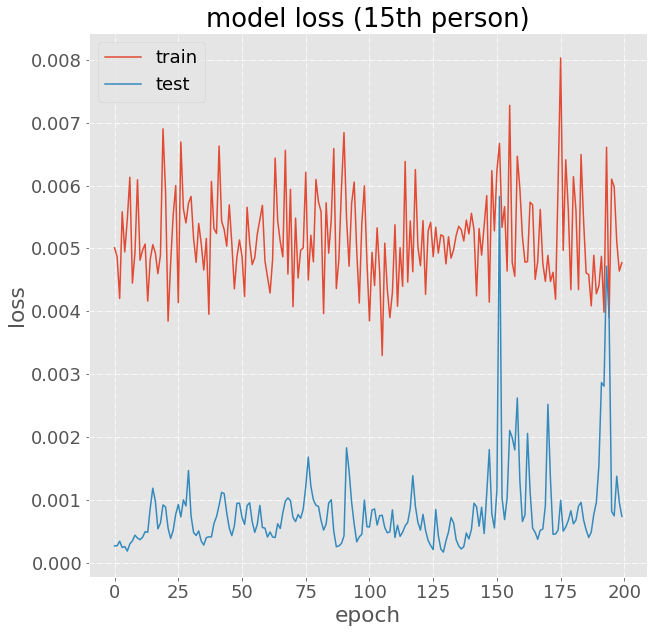

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 438us/step - loss: 0.0059 - val_loss: 8.0004e-04
Epoch 2/200
200/200 [==============================] - 0s 318us/step - loss: 0.0041 - val_loss: 9.1988e-04
Epoch 3/200
200/200 [==============================] - 0s 315us/step - loss: 0.0058 - val_loss: 6.5733e-04
Epoch 4/200
200/200 [==============================] - 0s 312us/step - loss: 0.0045 - val_loss: 4.0660e-04
Epoch 5/200
200/200 [==============================] - 0s 391us/step - loss: 0.0058 - val_loss: 2.7980e-04
Epoch 6/200
200/200 [==============================] - 0s 318us/step - loss: 0.0065 - val_loss: 4.8615e-04
Epoch 7/200
200/200 [==============================] - 0s 320us/step - loss: 0.0046 - val_loss: 5.5339e-04
Epoch 8/200
200/200 [==============================] - 0s 322us/step - loss: 0.0064 - val_loss: 8.3237e-04
Epoch 9/200
200/200 [==============================] - 0s 399us/step - loss: 0.0037 - val_loss: 4.7

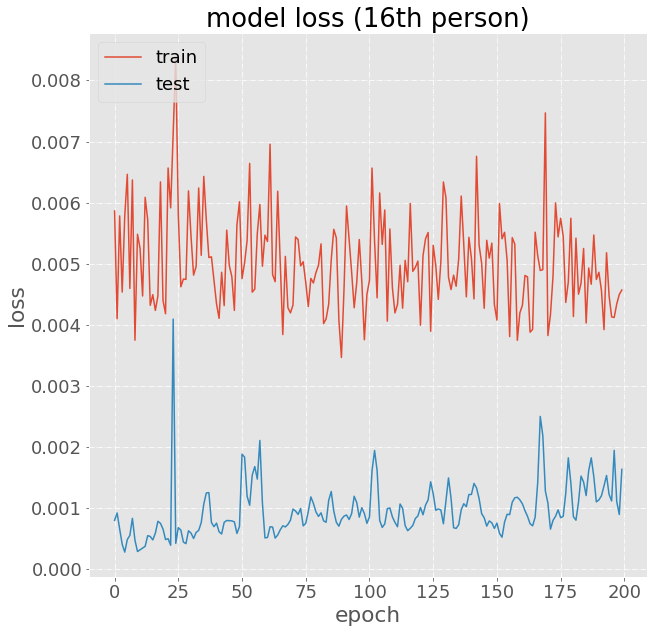

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 336us/step - loss: 0.0047 - val_loss: 3.2337e-04
Epoch 2/200
200/200 [==============================] - 0s 314us/step - loss: 0.0047 - val_loss: 4.3412e-04
Epoch 3/200
200/200 [==============================] - 0s 307us/step - loss: 0.0050 - val_loss: 6.0699e-04
Epoch 4/200
200/200 [==============================] - 0s 358us/step - loss: 0.0056 - val_loss: 5.7636e-04
Epoch 5/200
200/200 [==============================] - 0s 309us/step - loss: 0.0048 - val_loss: 5.9712e-04
Epoch 6/200
200/200 [==============================] - 0s 328us/step - loss: 0.0048 - val_loss: 5.9801e-04
Epoch 7/200
200/200 [==============================] - 0s 310us/step - loss: 0.0047 - val_loss: 4.2207e-04
Epoch 8/200
200/200 [==============================] - 0s 364us/step - loss: 0.0054 - val_loss: 4.0459e-04
Epoch 9/200
200/200 [==============================] - 0s 317us/step - loss: 0.0045 - val_loss: 4.7

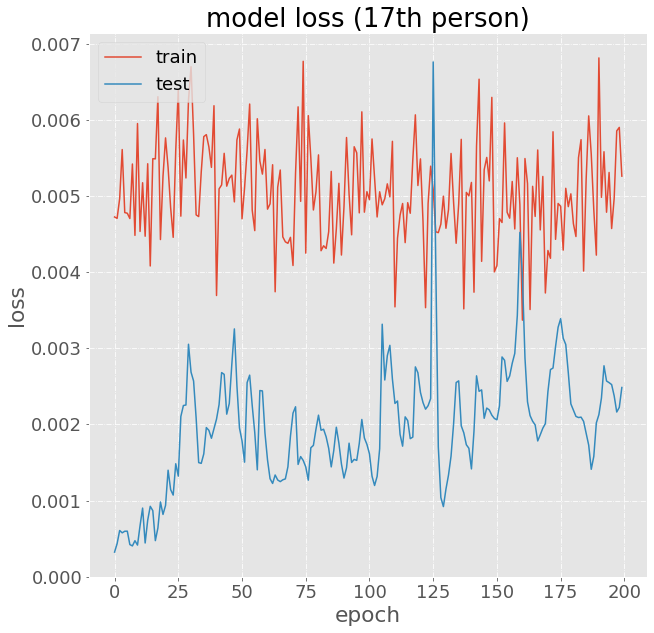

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 387us/step - loss: 0.0053 - val_loss: 5.9218e-04
Epoch 2/200
200/200 [==============================] - 0s 311us/step - loss: 0.0060 - val_loss: 0.0011
Epoch 3/200
200/200 [==============================] - 0s 317us/step - loss: 0.0045 - val_loss: 5.4962e-04
Epoch 4/200
200/200 [==============================] - 0s 329us/step - loss: 0.0053 - val_loss: 6.1696e-04
Epoch 5/200
200/200 [==============================] - 0s 334us/step - loss: 0.0051 - val_loss: 7.5902e-04
Epoch 6/200
200/200 [==============================] - 0s 324us/step - loss: 0.0046 - val_loss: 8.9236e-04
Epoch 7/200
200/200 [==============================] - 0s 323us/step - loss: 0.0043 - val_loss: 7.1532e-04
Epoch 8/200
200/200 [==============================] - 0s 335us/step - loss: 0.0044 - val_loss: 0.0012
Epoch 9/200
200/200 [==============================] - 0s 331us/step - loss: 0.0050 - val_loss: 0.0012
Epoc

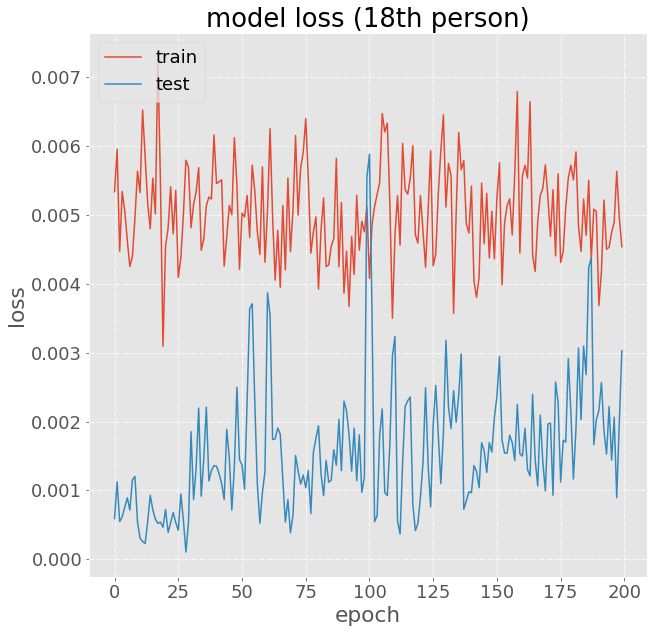

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 320us/step - loss: 0.0054 - val_loss: 7.3837e-04
Epoch 2/200
200/200 [==============================] - 0s 318us/step - loss: 0.0049 - val_loss: 0.0013
Epoch 3/200
200/200 [==============================] - 0s 306us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 4/200
200/200 [==============================] - 0s 324us/step - loss: 0.0038 - val_loss: 9.4044e-04
Epoch 5/200
200/200 [==============================] - 0s 336us/step - loss: 0.0040 - val_loss: 8.0171e-04
Epoch 6/200
200/200 [==============================] - 0s 333us/step - loss: 0.0042 - val_loss: 8.3996e-04
Epoch 7/200
200/200 [==============================] - 0s 358us/step - loss: 0.0042 - val_loss: 9.6752e-04
Epoch 8/200
200/200 [==============================] - 0s 418us/step - loss: 0.0048 - val_loss: 0.0012
Epoch 9/200
200/200 [==============================] - 0s 330us/step - loss: 0.0047 - val_loss: 9.9820e-04
Epoc

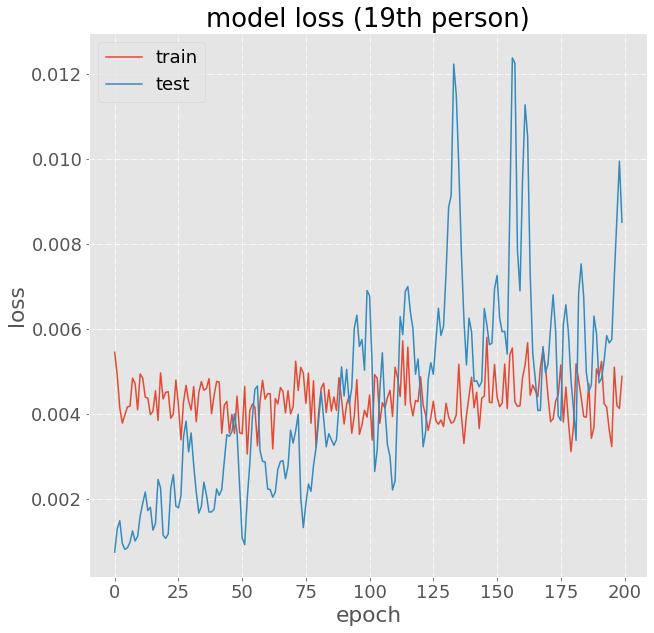

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 412us/step - loss: 0.0049 - val_loss: 1.7978e-04
Epoch 2/200
200/200 [==============================] - 0s 314us/step - loss: 0.0041 - val_loss: 4.0971e-04
Epoch 3/200
200/200 [==============================] - 0s 312us/step - loss: 0.0054 - val_loss: 1.6185e-04
Epoch 4/200
200/200 [==============================] - 0s 334us/step - loss: 0.0055 - val_loss: 1.1713e-04
Epoch 5/200
200/200 [==============================] - 0s 356us/step - loss: 0.0042 - val_loss: 1.1924e-04
Epoch 6/200
200/200 [==============================] - 0s 313us/step - loss: 0.0052 - val_loss: 6.8220e-05
Epoch 7/200
200/200 [==============================] - 0s 313us/step - loss: 0.0047 - val_loss: 1.5027e-04
Epoch 8/200
200/200 [==============================] - 0s 321us/step - loss: 0.0060 - val_loss: 2.7718e-04
Epoch 9/200
200/200 [==============================] - 0s 318us/step - loss: 0.0044 - val_loss: 1.8

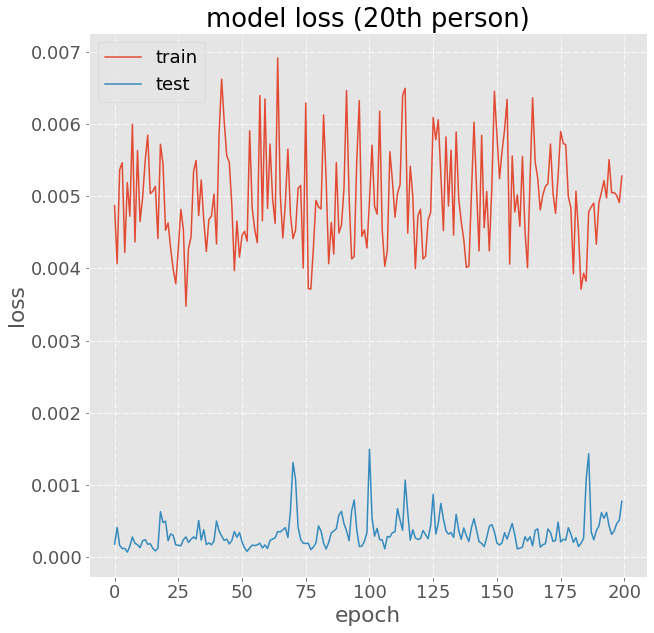

Train on 200 samples, validate on 10 samples
Epoch 1/200
200/200 [==============================] - 0s 355us/step - loss: 0.0045 - val_loss: 5.8336e-04
Epoch 2/200
200/200 [==============================] - 0s 336us/step - loss: 0.0054 - val_loss: 5.6459e-04
Epoch 3/200
200/200 [==============================] - 0s 319us/step - loss: 0.0043 - val_loss: 7.0114e-04
Epoch 4/200
200/200 [==============================] - 0s 327us/step - loss: 0.0046 - val_loss: 5.0198e-04
Epoch 5/200
200/200 [==============================] - 0s 325us/step - loss: 0.0038 - val_loss: 5.8354e-04
Epoch 6/200
200/200 [==============================] - 0s 387us/step - loss: 0.0034 - val_loss: 5.6173e-04
Epoch 7/200
200/200 [==============================] - 0s 326us/step - loss: 0.0044 - val_loss: 4.6672e-04
Epoch 8/200
200/200 [==============================] - 0s 319us/step - loss: 0.0042 - val_loss: 4.9285e-04
Epoch 9/200
200/200 [==============================] - 0s 350us/step - loss: 0.0057 - val_loss: 4.6

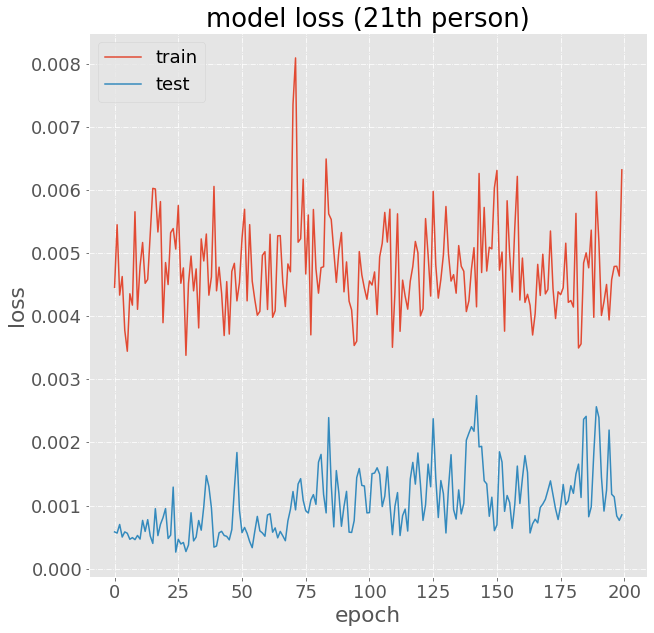

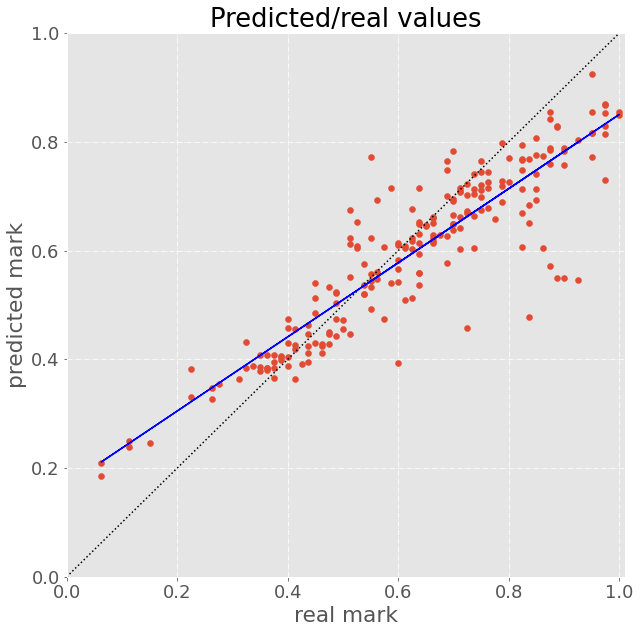

RMSE test 0.006756689205454653
corr test 0.9003744197742787


In [64]:
TEST_PRED = []
TEST_TRUE = []

for i in range(21):
	ind_test = np.where((Personnes == (i + 1)))
	ind_test = np.array(ind_test)
	X_test , y_test, X_train, y_train = split_data(X,y, ind_test)
	history = model.fit(X_train, y_train, epochs=nb_epochs, verbose=1,
	                    validation_data=(X_test, y_test), shuffle=True,
											batch_size=batch_size)
	print_history(history, str(ind_test[0][0]//10 +1))

	test = model.predict(X_test)
	TEST_PRED.append(test)
	TEST_TRUE.append(y_test)

TEST_TRUE = np.reshape(np.array(TEST_TRUE), 210)
TEST_PRED = np.reshape(np.array(TEST_PRED), 210)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(TEST_TRUE, TEST_PRED)
ax.plot(np.linspace(0,1),np.linspace(0,1), 'k:')
ax.set(title='Predicted/real values', xlabel='real mark',
         ylabel='predicted mark', xlim=(0,1.01), ylim=(0,1))
ax.grid(True, linestyle='-.')
slope, intercept, _, _, _ = stats.linregress(TEST_TRUE, TEST_PRED)
def linregr_predict(x):
   return slope * x + intercept
fitLine = linregr_predict(TEST_TRUE)
ax.plot(TEST_TRUE, fitLine, 'b-')
plt.show()
fig.savefig(PATH + 'cnn_test4_results_3' + '.eps', format='eps', dpi=1200)

RMSE_test=np.linalg.norm(TEST_PRED-TEST_TRUE)/len(TEST_TRUE)
print("RMSE test", RMSE_test)
test = np.reshape(TEST_PRED,TEST_PRED.shape[0])
r = np.corrcoef(TEST_TRUE, TEST_PRED)
print("corr test",  r[0,1])

Récupérer les résultats du modèle

In [0]:
#print_results(model, X_test, y_test, X_train, y_train)

Sauvegarder le modèle

In [0]:
model.save(PATH + "cnn_test4_3.h5")